In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from scipy.signal import medfilt

In [2]:
var = "total_precipitation" #Choose "wind_speed", "current_speed", "combined_wave_index", "total_precipitation"
PSD_dir = "../../../../data/test_correlation/data_mahy"
variable_dir = f"../../../../data/test_correlation/data_soundscape/{var}"

In [3]:
# Name and unit catalog for each variable
var_info = {
    "combined_wave_index": ("Combined wave index", "m/s"),
    "current_speed": ("Current speed", "m/s"),
    "wind_speed": ("Wind speed", "m/s"),
    "total_precipitation": ("Total precipitation", "m")
}
var_name, unit = var_info.get(var, ("Unknown variable", ""))

In [4]:
# select the stations you want to plot. /!\ You can only choose stations for one hydrophone
selected_stations = ["MAHY01",
                     "MAHY11",
                     "MAHY21",
                     "MAHY31",
                     "MAHY41"
                     ]

hydrophone_number = [station[-1] for station in selected_stations]
# check that only one hydrophone is chosen
if len(set(hydrophone_number))>1:
    raise ValueError("You have selected more than one hydrophone")
else:
    print(f"Hydrophone n°{hydrophone_number[0]} selected")

Hydrophone n°1 selected


In [5]:
# load the PSD data
psds_all = []
for station in selected_stations:
    psd_path = os.path.join(PSD_dir, f"{station}.pkl")
    psds_all.append(pd.read_pickle(psd_path))
# concatenate psds
psd_df = pd.concat(psds_all).sort_index()

# load the variable data
variable_path = os.path.join(variable_dir, f"h{hydrophone_number[0]}.pkl")
variable_df = pd.read_pickle(variable_path)

# keep lines of variable_df only if their date is in psd_df
variable_df = variable_df[variable_df.index.isin(psd_df.index)]

/tmp/ipykernel_29943/2583014491.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(loc="upper left")


(0.0, 0.014167405106127262)

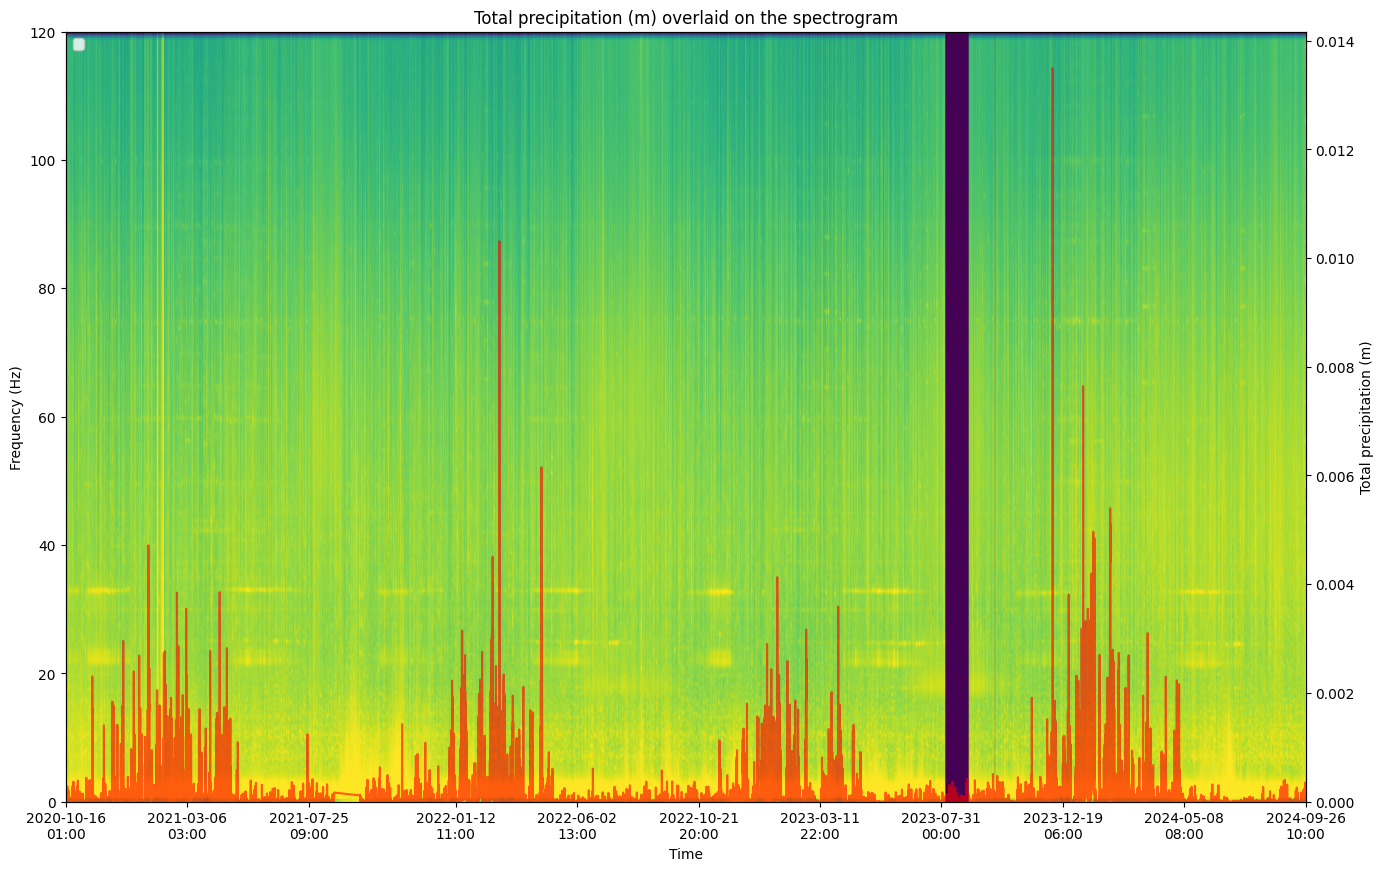

In [6]:
# plot
fig, ax1 = plt.subplots(figsize = (16,10))
ax2 = ax1.twinx() # Second axis for combined_wave_index index

sp = ax1.imshow(10*np.log10(psd_df.T + 1e-12), aspect="auto", origin="lower", cmap="viridis", extent=(psd_df.index[0].timestamp(), psd_df.index[-1].timestamp(),  psd_df.columns[0], psd_df.columns[-1]), vmin=10, vmax=95)
ax1.grid(False, axis='y')

# Trace combined_wave_index index on the second axis
ax2.plot(
    [t.timestamp() for t in variable_df.index],
    variable_df["values"].values,
    color='red',
    alpha=0.6
)

# display of dates on x-axis
ax1.set_xticks([
    ts.timestamp() for ts in psd_df.index[::len(psd_df)//10]
])
ax1.set_xticklabels([
    ts.strftime("%Y-%m-%d\n%H:%M") for ts in psd_df.index[::len(psd_df)//10]]
)

# Add labels
ax1.set_xlabel("Time")
ax1.set_ylabel("Frequency (Hz)")
ax2.set_ylabel(f"{var_name} ({unit})")
ax1.legend(loc="upper left")
ax1.set_title(f"{var_name} ({unit}) overlaid on the spectrogram")
ax2.set_ylim(bottom=0)

In [7]:
# Align common dates (est-ce vraiment nécessaire ?)
common_index = psd_df.index.intersection(variable_df.index)
psd_aligned = psd_df.loc[common_index]
variable_aligned = variable_df.loc[common_index]["values"]

correlations = []

for freq in psd_aligned.columns:
    amplitude = psd_aligned[freq]
    #NaN filter
    mask = (~np.isnan(amplitude)) & (~np.isnan(variable_aligned))
    if mask.sum() > 2:
        corr = np.corrcoef(amplitude[mask], variable_aligned[mask])[0,1]
    else:
        corr = np.nan
    correlations.append(corr)

frequencies = psd_aligned.columns

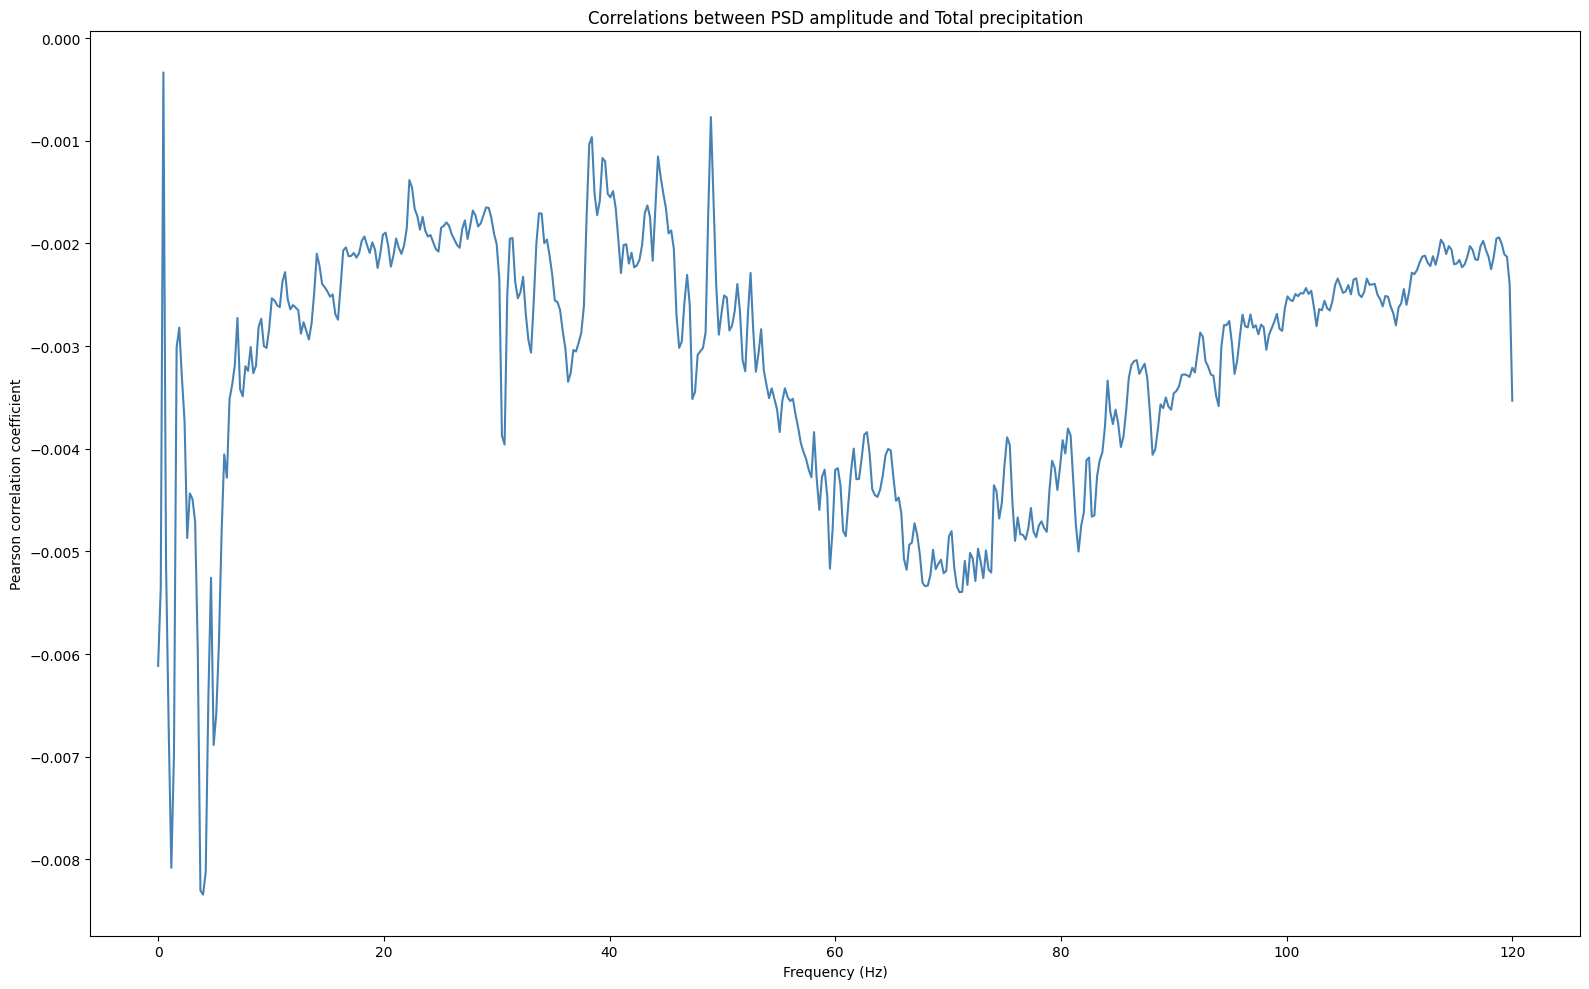

In [8]:
# Plot
plt.figure(figsize=(16,10))
plt.plot(frequencies, correlations, color="steelblue")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Pearson correlation coefficient")
plt.title(f"Correlations between PSD amplitude and {var_name}")

plt.tight_layout()
plt.show()

In [9]:
# Align common dates (est-ce vraiment nécessaire ?)
common_index = psd_df.index.intersection(variable_df.index)
psd_aligned = psd_df.loc[common_index]
variable_aligned = variable_df.loc[common_index]["values"]

correlations = []

for freq in psd_aligned.columns:
    amplitude = psd_aligned[freq]
    amplitude_filt = medfilt(amplitude, kernel_size=51)
    #NaN filter
    mask = (~np.isnan(amplitude_filt)) & (~np.isnan(variable_aligned))
    if mask.sum() > 2:
        corr = np.corrcoef(amplitude_filt[mask], variable_aligned[mask])[0,1]
    else:
        corr = np.nan
    correlations.append(corr)

frequencies = psd_aligned.columns

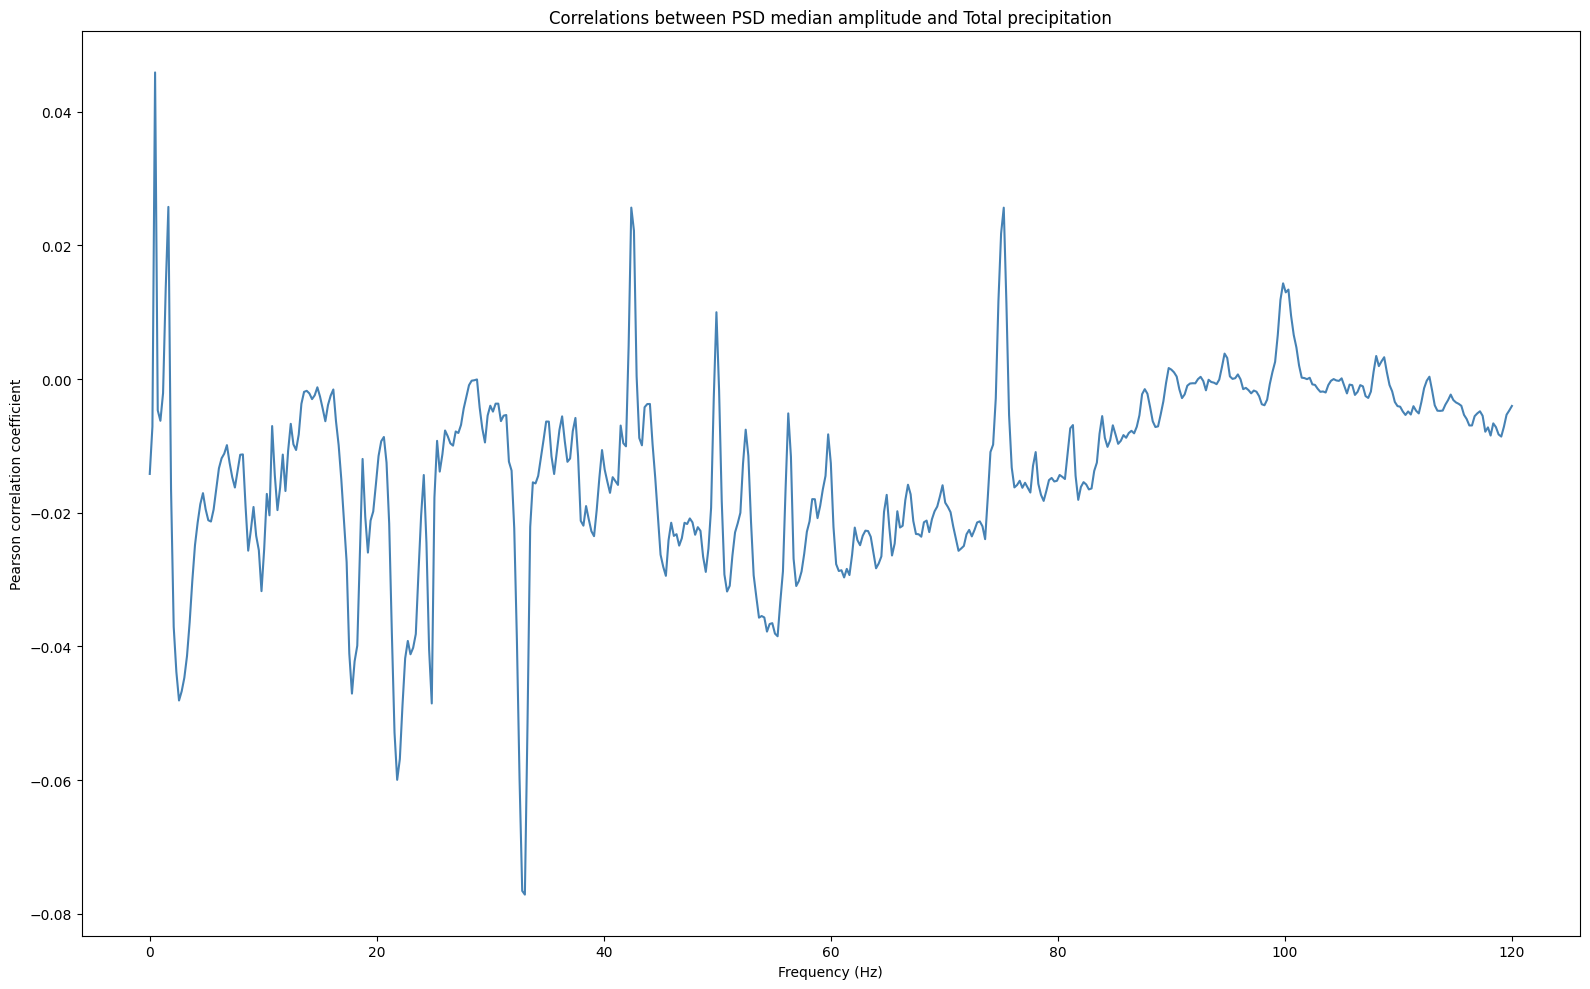

In [10]:
# Plot
plt.figure(figsize=(16,10))
plt.plot(frequencies, correlations, color="steelblue")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Pearson correlation coefficient")
plt.title(f"Correlations between PSD median amplitude and {var_name}")

plt.tight_layout()
plt.show()